# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [196]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-07-25/data_eval_new/"
file_name = "int_norm_20160725_bgd_old.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [197]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [5]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [198]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

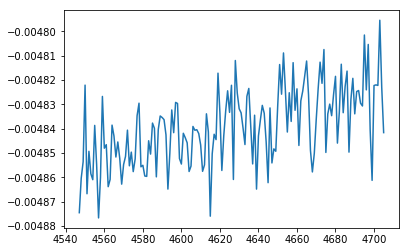

In [199]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

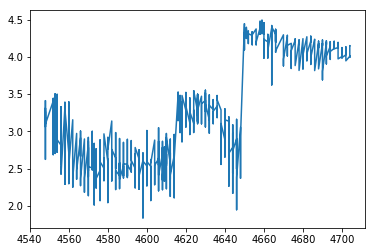

In [200]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

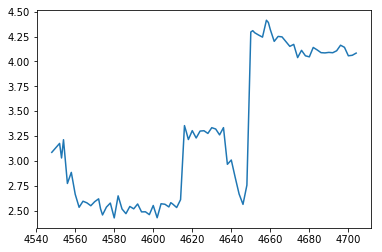

In [201]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

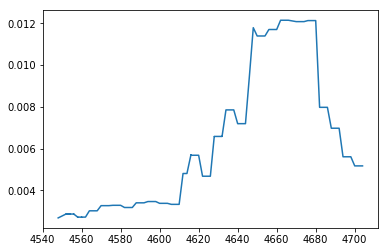

In [202]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [203]:
background_mean = df_mean(background)

# Outlier rejection

In [259]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_122_118"
interf_corr = "Te125_Xe129_corr"

In [260]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [261]:
column = "124/118"
sample = "NIST 200ppb"

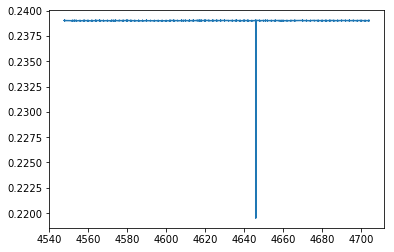

In [262]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [263]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [264]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,,,
2016-07-25 19:37:00,NIST 200ppb,2,1,4548,0.040140,NaN,0.013943,0.600305,0.316723,0.354646,1.345889,0.19125,0.239029
2016-07-25 19:37:00,NIST 200ppb,2,2,4548,0.040144,0.027176,0.013942,0.600292,0.316732,0.354631,1.345939,0.19125,0.239012
2016-07-25 19:37:00,NIST 200ppb,2,3,4548,0.040139,0.027176,0.013941,0.600298,0.316722,0.354644,1.345930,0.19125,0.239005
2016-07-25 19:37:00,NIST 200ppb,2,4,4548,0.040139,0.027172,0.013945,0.600325,0.316728,0.354652,1.345911,0.19125,0.239020
2016-07-25 19:37:00,NIST 200ppb,2,5,4548,0.040143,0.027177,0.013945,0.600320,0.316730,0.354642,1.345925,NaN,0.239012
2016-07-25 19:37:00,NIST 200ppb,2,6,4548,0.040135,0.027169,0.013944,0.600311,0.316728,0.354645,1.345943,NaN,0.239009
2016-07-25 19:37:00,NIST 200ppb,2,7,4548,0.040138,0.027174,0.013940,0.600284,0.316739,0.354653,1.345979,0.19125,0.239001
2016-07-25 19:37:00,NIST 200ppb,2,8,4548,0.040141,0.027172,0.013944,0.600307,0.316732,0.354642,1.345944,NaN,0.239009
2016-07-25 19:37:00,NIST 200ppb,2,9,4548,0.040140,0.027173,0.013943,0.600297,0.316718,0.354631,1.345952,NaN,0.239011


In [265]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
4555        2016-07-25 21:11:00    0.259036
            2016-07-25 21:11:00    0.258958
4560        2016-07-25 22:17:00    0.259121
            2016-07-25 22:17:00    0.259120
            2016-07-25 22:17:00    0.259116
4564        2016-07-25 23:08:00    0.259070
            2016-07-25 23:08:00    0.259078
4566        2016-07-25 23:36:00    0.259174
            2016-07-25 23:36:00    0.259191
4573        2016-07-26 01:08:00    0.258739
            2016-07-26 01:08:00    0.258735
4578        2016-07-26 02:13:00    0.259251
4579        2016-07-26 02:27:00    0.259171
4588        2016-07-26 04:23:00    0.259173
            2016-07-26 04:23:00    0.259202
            2016-07-26 04:23:00    0.259180
4590        2016-07-26 04:50:00    0.259158
4592        2016-07-26 05:18:00    0.259101
4600        2016-07-26 07:00:00    0.259258
4629        2016-07-26 14:18:00    0.259129
4638        2016-07-26 16:26:00    0.258762
4646        2016-07-26 18:10:00    0.228298


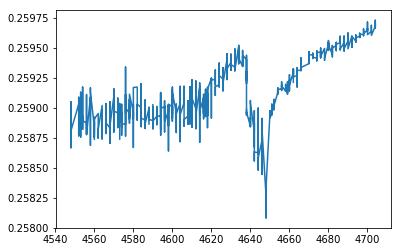

In [266]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [267]:
df[df["Sample"] == sample][column].std()

0.0002906868752264869

In [268]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

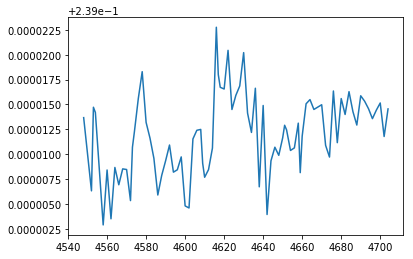

In [269]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [270]:
data_mean_int

,Filenumber,Sample,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,
2016-07-25 19:37:00,4548,NIST 200ppb,0.040139,0.027173,0.013944,0.600304,0.316730,0.354645,1.345936,0.19125,0.239014
2016-07-25 20:06:00,4550,NIST 350ppb,0.040145,0.027177,0.013945,0.600324,0.316735,0.354641,1.345917,0.19125,0.239008
2016-07-25 20:30:00,4552,NIST 200ppb,0.040142,0.027174,0.013945,0.600309,0.316736,0.354644,1.345943,0.19125,0.239006
2016-07-25 20:44:00,4553,NIST 200ppb,0.040142,0.027179,0.013945,0.600304,0.316733,0.354641,1.345944,0.19125,0.239015
2016-07-25 20:57:00,4554,NIST 200ppb,0.040144,0.027177,0.013946,0.600316,0.316735,0.354643,1.345951,0.19125,0.239014
2016-07-25 21:11:00,4555,NIST 350ppb,0.040142,0.027175,0.013945,0.600310,0.316736,0.354640,1.345922,0.19125,0.239009
2016-07-25 21:25:00,4556,NIST 200ppb,0.040142,0.027176,0.013946,0.600300,0.316734,0.354640,1.345950,0.19125,0.239009
2016-07-25 21:49:00,4558,NIST 200ppb,0.040143,0.027176,0.013948,0.600322,0.316741,0.354639,1.345945,0.19125,0.239003
2016-07-25 22:03:00,4559,NIST 350ppb,0.040143,0.027176,0.013945,0.600322,0.316740,0.354638,1.345934,0.19125,0.239010


In [271]:
date_list = []
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [272]:
drop_sum = [pd.Timestamp('2016-07-26 11:25:00'), 
            pd.Timestamp('2016-07-26 18:10:00'), 
            pd.Timestamp('2016-07-26 18:47:00')]

In [273]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [274]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [275]:
data_mean_int_sum

112/118                   114/118                \
                               mean       SD2 count      mean           SD2   
Sample                                                                        
Allende bomb 1_2           0.040144       NaN     1  0.027173           NaN   
J.W bomb 1_1               0.040143       NaN     1  0.027172           NaN   
J.W. bomb 1_2              0.040138       NaN     1  0.027173           NaN   
Murchison bomb 1_1         0.040141       NaN     1  0.027176           NaN   
NIST 200ppb                0.040145  0.000007    80  0.027176  4.475142e-06   
NIST 200ppb + 0.005ppb U   0.040145  0.000009     4  0.027177  9.619505e-07   
NIST 200ppb + 0.015ppb U   0.040141       NaN     1  0.027177           NaN   
NIST 200ppb + 0.030ppb Cd  0.040147  0.000006     5  0.027181  3.266834e-06   
NIST 200ppb + 0.040ppb Cd  0.040145  0.000021     2  0.027181  1.186776e-05   
NIST 200ppb + 0.100ppb Zr  0.040147  0.000015     2  0.027179  9.161484e-06   
NIST 200ppb + 0.150ppb Rh  0.040144  0.000011     2  0.027176  4.352062e-06   
NIST 200ppb + 0.200ppb Ru  0.040147  0.000012     2  0.027178  9.448631e-06   
NIST 200ppb + 0.250ppb Pd  0.040144  0.000006     4  0.027176  5.409569e-06   
NIST 200ppb + 0.800ppb Mo  0.040145  0.000007     4  0.027177  4.607058e-06   
NIST 350ppb                0.040147  0.000010    13  0.027177  4.252315e-06   
ZH09-05 23.3 1_4           0.040147       NaN     1  0.027176           NaN   

                                  115/118                   116/118  ...   \
                          count      mean       SD2 count      mean  ...    
Sample                                                               ...    
Allende bomb 1_2              1  0.013943       NaN     1  0.600322  ...    
J.W bomb 1_1                  1  0.013943       NaN     1  0.600324  ...    
J.W. bomb 1_2                 1  0.013941       NaN     1  0.600308  ...    
Murchison bomb 1_1            1  0.013943       NaN     1  0.600318  ...    
NIST 200ppb                  80  0.013946  0.000002    80  0.600324  ...    
NIST 200ppb + 0.005ppb U      4  0.013946  0.000001     4  0.600322  ...    
NIST 200ppb + 0.015ppb U      1  0.013946       NaN     1  0.600304  ...    
NIST 200ppb + 0.030ppb Cd     5  0.013946  0.000002     5  0.600325  ...    
NIST 200ppb + 0.040ppb Cd     2  0.013947  0.000003     2  0.600327  ...    
NIST 200ppb + 0.100ppb Zr     2  0.013946  0.000001     2  0.600333  ...    
NIST 200ppb + 0.150ppb Rh     2  0.013946  0.000002     2  0.600324  ...    
NIST 200ppb + 0.200ppb Ru     2  0.013945  0.000005     2  0.600330  ...    
NIST 200ppb + 0.250ppb Pd     4  0.013946  0.000001     4  0.600320  ...    
NIST 200ppb + 0.800ppb Mo     4  0.013946  0.000003     4  0.600326  ...    
NIST 350ppb                  13  0.013947  0.000003    13  0.600341  ...    
ZH09-05 23.3 1_4              1  0.013946       NaN     1  0.600318  ...    

                          119/118   120/118                  122/118  \
                            count      mean       SD2 count     mean   
Sample                                                                 
Allende bomb 1_2                1  1.345948       NaN     1  0.19125   
J.W bomb 1_1                    1  1.345943       NaN     1  0.19125   
J.W. bomb 1_2                   1  1.345958       NaN     1  0.19125   
Murchison bomb 1_1              1  1.345954       NaN     1  0.19125   
NIST 200ppb                    80  1.345946  0.000022    80  0.19125   
NIST 200ppb + 0.005ppb U        4  1.345945  0.000021     4  0.19125   
NIST 200ppb + 0.015ppb U        1  1.345954       NaN     1  0.19125   
NIST 200ppb + 0.030ppb Cd       5  1.345946  0.000015     5  0.19125   
NIST 200ppb + 0.040ppb Cd       2  1.345940  0.000008     2  0.19125   
NIST 200ppb + 0.100ppb Zr       2  1.345933  0.000036     2  0.19125   
NIST 200ppb + 0.150ppb Rh       2  1.345940  0.000013     2  0.19125   
NIST 200ppb + 0.200ppb Ru       2  1.345947  0.000029 

In [276]:
date_list = []


epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)

In [277]:

date_list = [pd.Timestamp('2016-07-25 20:30:00'),
             pd.Timestamp('2016-07-26 10:04:00'),
             pd.Timestamp('2016-07-26 11:25:00'),
             pd.Timestamp('2016-07-26 11:39:00'),
             pd.Timestamp('2016-07-26 18:10:00'),
             pd.Timestamp('2016-07-26 18:47:00'),
             pd.Timestamp('2016-07-26 19:19:00')]

epsilon_int_200 = epsilon_int_200.drop(date_list)
delta_raw_200 = delta_raw_200.drop(date_list)

In [278]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -10) & (df["Filenumber"] <= 10)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [279]:
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = epsilon_process(delta_raw_200)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [280]:
epsilon_int_200

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-07-25 20:06:00,4550,1.043577,1.475398,0.213216,0.286635,0.062101,-0.081156,-0.170246,0.000000e+00,-0.066473,NIST 350ppb
2016-07-25 20:44:00,4553,-0.409438,1.103644,-0.688919,-0.134157,-0.104308,-0.070665,-0.020704,-1.110223e-12,0.186910,NIST 200ppb
2016-07-25 20:57:00,4554,0.636631,0.090625,0.656449,0.223888,0.071980,0.061930,0.024407,2.220446e-12,0.107434,NIST 200ppb
2016-07-25 21:11:00,4555,-0.239729,-0.539037,-1.046230,0.026879,0.051582,-0.045529,-0.209600,-3.330669e-12,-0.102804,NIST 350ppb
2016-07-25 21:25:00,4556,-0.394014,-0.416388,-0.730614,-0.308952,-0.140969,-0.026804,0.020629,-1.110223e-12,-0.000147,NIST 200ppb
2016-07-25 21:49:00,4558,-0.279261,-0.204841,1.018000,0.163040,0.048066,-0.093614,-0.093727,2.220446e-12,-0.233807,NIST 200ppb
2016-07-25 22:03:00,4559,-0.252305,-0.434226,-1.256534,-0.017172,-0.098715,-0.111650,-0.153486,-3.330669e-12,0.165978,NIST 350ppb
2016-07-25 22:17:00,4560,0.699322,0.680120,-0.473943,0.085876,0.122577,0.051600,0.095260,-1.110223e-12,0.218245,NIST 200ppb
2016-07-25 22:30:00,4561,-0.763359,0.205374,-0.580892,0.000480,-0.072550,-0.070481,-0.253931,2.220446e-12,0.094904,NIST 350ppb


In [281]:
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_int_200_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_200_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [254]:
epsilon_sum_all

112/120              114/120              115/120  \
                             mean    SD2 count    mean    SD2 count    mean   
Sample                                                                        
Allende bomb 1_2            0.339    NaN     1  -0.121    NaN     1  -2.371   
J.W bomb 1_1               -0.485    NaN     1  -1.164    NaN     1  -2.114   
J.W. bomb 1_2              -0.003    NaN     1   1.171    NaN     1  -2.878   
Murchison bomb 1_1          0.217    NaN     1   1.434    NaN     1  -2.286   
NIST 200ppb                -0.002  0.759    74   0.017  1.376    74   0.006   
NIST 200ppb + 0.005ppb U    0.185  1.149     4   0.351  0.501     4   0.085   
NIST 200ppb + 0.015ppb U    0.357    NaN     1   1.135    NaN     1  -0.177   
NIST 200ppb + 0.030ppb Cd   0.216  0.862     5   1.704  1.434     5  -0.119   
NIST 200ppb + 0.040ppb Cd  -0.012  1.988     2   1.939  2.460     2   0.161   
NIST 200ppb + 0.100ppb Zr   0.373  0.461     2   0.907  1.448     2   0.168   
NIST 200ppb + 0.150ppb Rh   0.007  0.436     2   0.286  0.131     2  -0.378   
NIST 200ppb + 0.200ppb Ru   0.221  0.757     2   0.609  2.941     2  -0.670   
NIST 200ppb + 0.250ppb Pd   0.123  0.940     4   0.334  0.471     4   0.309   
NIST 200ppb + 0.800ppb Mo   0.306  0.989     4   0.567  0.603     4   0.046   
NIST 350ppb                -0.246  0.788    13  -0.139  1.236    13  -0.249   
ZH09-05 23.3 1_4           -0.289    NaN     1  -0.452    NaN     1  -0.344   

                                       116/120  ...  118/120 119/120         \
                             SD2 count    mean  ...    count    mean    SD2   
Sample                                          ...                           
Allende bomb 1_2             NaN     1    -0.0  ...        1  -0.004    NaN   
J.W bomb 1_1                 NaN     1     0.0  ...        1   0.028    NaN   
J.W. bomb 1_2                NaN     1     0.0  ...        1  -0.023    NaN   
Murchison bomb 1_1           NaN     1    -0.0  ...        1   0.065    NaN   
NIST 200ppb                1.057    74    -0.0  ...       74  -0.003  0.172   
NIST 200ppb + 0.005ppb U   0.762     4    -0.0  ...        4   0.136  0.099   
NIST 200ppb + 0.015ppb U     NaN     1     0.0  ...        1   0.369    NaN   
NIST 200ppb + 0.030ppb Cd  1.025     5     0.0  ...        5   0.047  0.099   
NIST 200ppb + 0.040ppb Cd  0.101     2    -0.0  ...        2  -0.074  0.312   
NIST 200ppb + 0.100ppb Zr  2.886     2    -0.0  ...        2   0.056  0.087   
NIST 200ppb + 0.150ppb Rh  1.254     2     0.0  ...        2   0.039  0.032   
NIST 200ppb + 0.200ppb Ru  1.348     2    -0.0  ...        2  -0.142  0.322   
NIST 200ppb + 0.250ppb Pd  0.292     4     0.0  ...        4   0.009  0.114   
NIST 200ppb + 0.800ppb Mo  1.172     4     0.0  ...        4   0.039  0.107   
NIST 350ppb                1.263    13     0.0  ...       13   0.037  0.153   
ZH09-05 23.3 1_4             NaN     1     0.0  ...        1  -0.232    NaN   

                                122/120              124/120               
                          count    mean    SD2 count    mean    SD2 count  
Sample                                                                     
Allende bomb 1_2              1  -0.226    NaN     1  -0.214    NaN     1  
J.W bomb 1_1                  1  -0.092    NaN     1  -0.184    NaN     1  
J.W. bomb 1_2                 1  -0.179    NaN     1  -0.503    NaN     1  
Murchison bomb 1_1            1  -0.014    NaN     1  -0.334    NaN     1  
NIST 200ppb                  74  -0.001  0.218    74  -0.003  0.336    74  
NIST 200ppb + 0.005ppb U      4  -0.017  0.187     4  -0.047  0.146     4  
NIST 200ppb + 0.015ppb U      1  -0.097    NaN     1   0.177    NaN     1  
NIST 200ppb + 0.030ppb Cd     5   0.006  0.235     5   0.072  0.209     5  
NIST 200ppb + 0.040ppb Cd     2   0.058  0.129     2   0.030  0.104     2  
NIST 200ppb + 0.100ppb Zr     2   0.125  0.377     2   0.190  0.051     2  
NIST 200ppb + 0.150ppb Rh     2  -

In [255]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

# Raw data to xls file

In [134]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [135]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [282]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_old.xlsx', engine='xlsxwriter')


In [283]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_200.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_200.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [284]:
writer_orig.save()

In [230]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [285]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')